In [1]:
!pip install xgboost
!pip install pandas scikit-learn matplotlib seaborn


In [2]:
from google.colab import files
uploaded = files.upload()


Saving archive (3).zip to archive (3).zip


In [3]:
import zipfile
import os


zip_file = 'archive (3).zip'


with zipfile.ZipFile(zip_file, 'r') as zip_ref:
    zip_ref.extractall('expedia_data')


os.listdir('expedia_data')


['Hotel_details.csv',
 'hotel_price_min_max - Formula.csv',
 'Hotel_Room_attributes.csv',
 'hotels_RoomPrice.csv']

In [4]:
import pandas as pd

hotel_details = pd.read_csv('expedia_data/Hotel_details.csv')
room_attributes = pd.read_csv('expedia_data/Hotel_Room_attributes.csv')
room_prices = pd.read_csv('expedia_data/hotels_RoomPrice.csv')
price_formula = pd.read_csv('expedia_data/hotel_price_min_max - Formula.csv')


In [5]:
print("Hotel Details:")
print(hotel_details.head())

print("\nRoom Attributes:")
print(room_attributes.head())

print("\nRoom Prices:")
print(room_prices.head())

print("\nPrice Formula:")
print(price_formula.head())


Hotel Details:
      id  hotelid                 hotelname                 address     city  \
0  46406  1771651  Mediteran Bungalow Galeb            Vukovarska 7     Omis   
1  46407   177167             Hotel Polonia        Plac Teatralny 5    Torun   
2  46408  1771675         Rifugio Sass Bece  Belvedere del Pordoi,1  Canazei   
3  46409   177168            Madalena Hotel                 Mykonos  Mykonos   
4  46410  1771718         Pension Morenfeld  Mair im Korn Strasse 2  Lagundo   

   country  zipcode   propertytype  starrating   latitude  longitude  Source  \
0  Croatia  21310.0  Holiday parks           4  43.440124  16.682505       2   
1   Poland      NaN         Hotels           3  53.012329  18.603800       5   
2    Italy  38032.0         Hotels           3  46.477920  11.813350       2   
3   Greece  84600.0         Hotels           3  37.452316  25.329849       5   
4    Italy  39022.0         Hotels           3  46.682780  11.131736       2   

                       

In [6]:
print("Hotel Details Columns:", hotel_details.columns.tolist())
print("Room Attributes Columns:", room_attributes.columns.tolist())
print("Room Prices Columns:", room_prices.columns.tolist())
print("Price Formula Columns:", price_formula.columns.tolist())


Hotel Details Columns: ['id', 'hotelid', 'hotelname', 'address', 'city', 'country', 'zipcode', 'propertytype', 'starrating', 'latitude', 'longitude', 'Source', 'url', 'curr']
Room Attributes Columns: ['id', 'hotelcode', 'roomamenities', 'roomtype', 'ratedescription']
Room Prices Columns: ['id', 'refid', 'hotelcode', 'websitecode', 'dtcollected', 'ratedate', 'los', 'guests', 'roomtype', 'onsiterate', 'netrate', 'currency', 'ratedescription', 'ratetype', 'sourceurl', 'roomamenities', 'maxoccupancy', 'ispromo', 'closed', 'discount', 'promoname', 'status_code', 'taxstatus', 'taxtype', 'taxamount', 'proxyused', 'israteperstay', 'mealinclusiontype', 'hotelblock', 'input_dtcollected']
Price Formula Columns: ['hotelcode', 'min', 'max', 'Diff_Min', 'Diff_Max', 'Score']


In [7]:

hotel_details.rename(columns={'hotelid': 'hotelcode'}, inplace=True)


In [8]:
# Merge Room Attributes with Room Prices on ['hotelcode', 'roomtype', 'roomamenities', 'ratedescription']

room_data = pd.merge(room_attributes, room_prices,
                     on=['hotelcode', 'roomtype', 'roomamenities', 'ratedescription'],
                     how='inner')


In [9]:
hotel_room_data = pd.merge(hotel_details, room_data, on='hotelcode', how='inner')


In [10]:
final_df = pd.merge(hotel_room_data, price_formula, on='hotelcode', how='left')


In [11]:
# Drop irrelevant columns
drop_cols = ['id_x', 'id_y', 'url', 'sourceurl', 'dtcollected', 'input_dtcollected', 'ratedate',
             'hotelblock', 'curr', 'currency', 'hotelname', 'address', 'zipcode']

df_clean = final_df.drop(columns=[col for col in drop_cols if col in final_df.columns])

# Drop rows with missing target
df_clean = df_clean.dropna(subset=['Score'])

# Define X and y
X = df_clean.drop(columns=['Score'])
y = df_clean['Score']


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()
for col in X.select_dtypes(include='object').columns:
    X[col] = le.fit_transform(X[col].astype(str))


X.fillna(-1, inplace=True)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [13]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

model = xgb.XGBRegressor()
model.fit(X_train, y_train)


y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")


Mean Squared Error: 0.00


In [14]:

print('Score' in X.columns)


False


In [15]:
print(y.value_counts())
print("Unique values in Score:", y.nunique())


Score
0.16     42861
0.21     42624
0.14     40492
0.17     39028
0.18     37553
         ...  
4.97         1
2.66         1
4.77         1
3.53         1
11.47        1
Name: count, Length: 464, dtype: int64
Unique values in Score: 464


In [17]:

valid_scores = y.value_counts()[y.value_counts() >= 3].index
X_filtered = X[y.isin(valid_scores)]
y_filtered = y[y.isin(valid_scores)]


from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42, stratify=y_filtered)


In [18]:

def score_to_class(score):
    if score < 1:
        return 'Low'
    elif score < 2:
        return 'Medium'
    else:
        return 'High'

y_class = y.apply(score_to_class)


from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_encoded = le.fit_transform(y_class)


X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)


In [19]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score

model = xgb.XGBRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluation
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))


MSE: 4.08168816647958e-05
R² Score: 0.9995714426040649


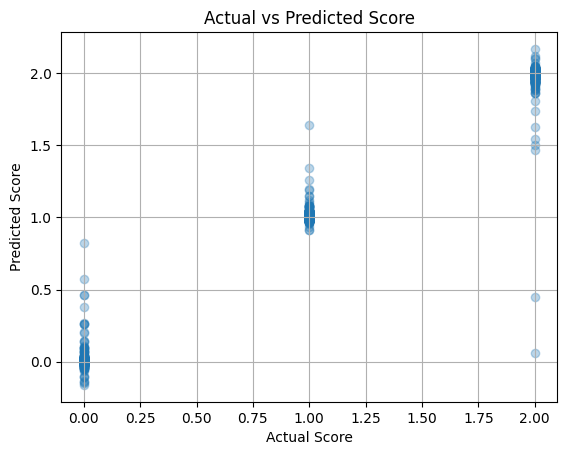

In [20]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.3)
plt.xlabel("Actual Score")
plt.ylabel("Predicted Score")
plt.title("Actual vs Predicted Score")
plt.grid(True)
plt.show()


In [21]:
import numpy as np

y_pred_rounded = np.round(y_pred).astype(int)


In [22]:
from sklearn.metrics import classification_report, accuracy_score

print("Rounded Accuracy:", accuracy_score(y_test, y_pred_rounded))
print(classification_report(y_test, y_pred_rounded, target_names=le.classes_))


Rounded Accuracy: 0.9999782663029895
              precision    recall  f1-score   support

        High       1.00      1.00      1.00      9886
         Low       1.00      1.00      1.00    249615
      Medium       1.00      1.00      1.00     16568

    accuracy                           1.00    276069
   macro avg       1.00      1.00      1.00    276069
weighted avg       1.00      1.00      1.00    276069



In [24]:
import numpy as np


predicted_class = np.round(model.predict(X_all)).astype(int)


X_all['Predicted_Class'] = le.inverse_transform(predicted_class)


In [25]:
# Add back some identifying columns
X_all['hotelname'] = final_df.loc[X_all.index, 'hotelname']
X_all['city'] = final_df.loc[X_all.index, 'city']
X_all['Score'] = final_df.loc[X_all.index, 'Score']

# Example: Top 5 High-score hotels in Delhi
top_hotels = X_all[(X_all['Predicted_Class'] == 'High') & (X_all['city'].str.lower() == 'delhi')]
top_hotels = top_hotels.sort_values(by='Score', ascending=False).head(5)

top_hotels[['hotelname', 'city', 'Predicted_Class', 'Score']]


,hotelname,city,Predicted_Class,Score


from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['index']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'index'}, axis=1)
              .sort_values('index', ascending=True))
  xs = counted['index']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_0.sort_values('index', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('index')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['Score']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'Score'}, axis=1)
              .sort_values('Score', ascending=True))
  xs = counted['Score']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_1.sort_values('Score', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Score')
_ = plt.ylabel('count()')

/tmp/ipython-input-26-2234884284.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=X_all, x='Predicted_Class', order=['Low', 'Medium', 'High'], palette='pastel')


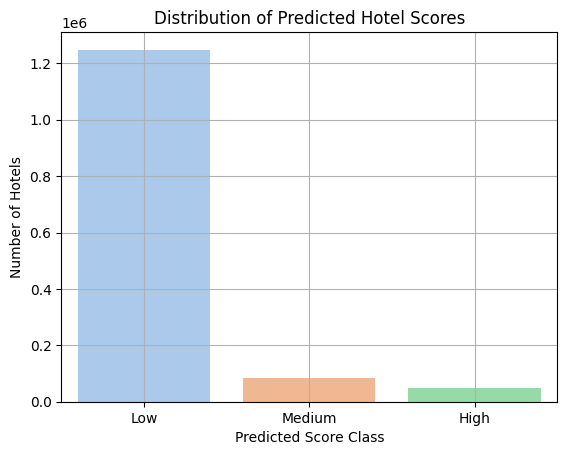

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=X_all, x='Predicted_Class', order=['Low', 'Medium', 'High'], palette='pastel')
plt.title("Distribution of Predicted Hotel Scores")
plt.xlabel("Predicted Score Class")
plt.ylabel("Number of Hotels")
plt.grid(True)
plt.show()


/tmp/ipython-input-27-2040553191.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_cities.values, y=top_cities.index, palette='Blues_r')


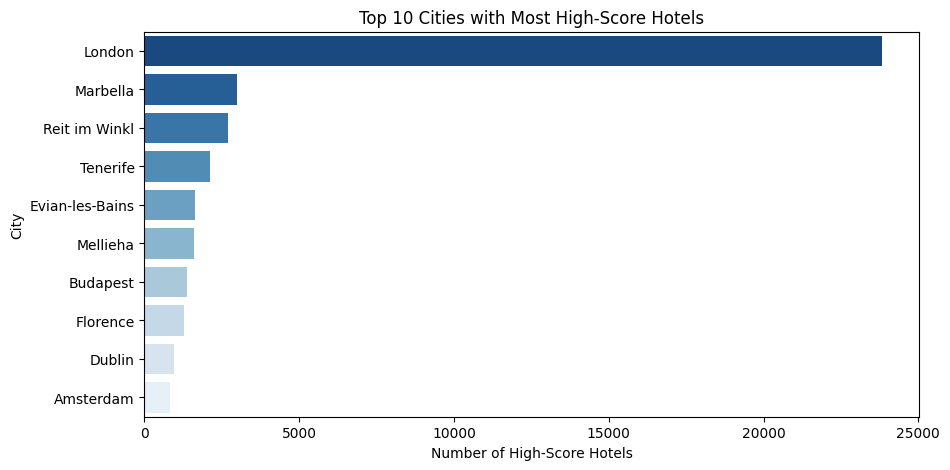

In [27]:
top_cities = X_all[X_all['Predicted_Class'] == 'High']['city'].value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.barplot(x=top_cities.values, y=top_cities.index, palette='Blues_r')
plt.title("Top 10 Cities with Most High-Score Hotels")
plt.xlabel("Number of High-Score Hotels")
plt.ylabel("City")
plt.show()


/tmp/ipython-input-28-3058175478.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_all, x='Predicted_Class', y='starrating', palette='Set2')


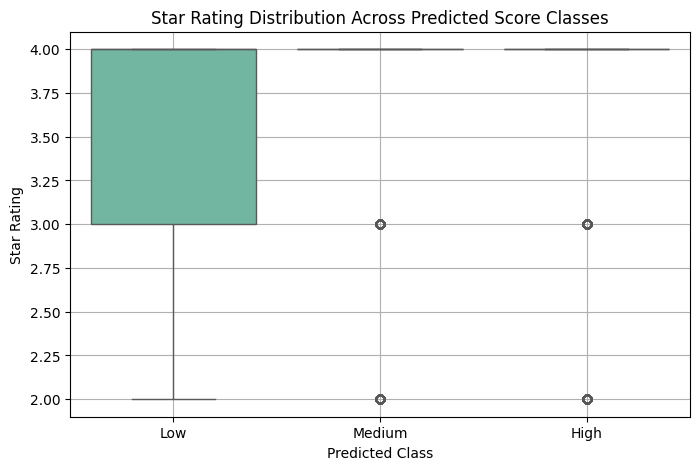

In [28]:
if 'starrating' in X_all.columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=X_all, x='Predicted_Class', y='starrating', palette='Set2')
    plt.title("Star Rating Distribution Across Predicted Score Classes")
    plt.xlabel("Predicted Class")
    plt.ylabel("Star Rating")
    plt.grid(True)
    plt.show()


/tmp/ipython-input-29-2941455692.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=X_all, x='Predicted_Class', y='onsiterate', palette='coolwarm')


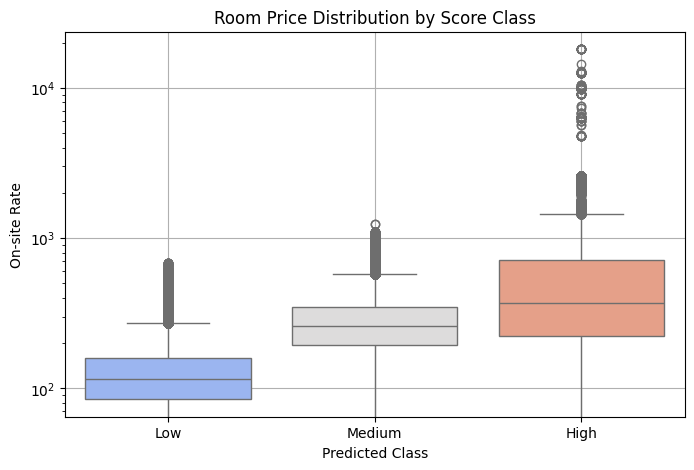

In [29]:
if 'onsiterate' in X_all.columns:
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=X_all, x='Predicted_Class', y='onsiterate', palette='coolwarm')
    plt.title("Room Price Distribution by Score Class")
    plt.xlabel("Predicted Class")
    plt.ylabel("On-site Rate")
    plt.yscale("log")  # If prices have extreme outliers
    plt.grid(True)
    plt.show()


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


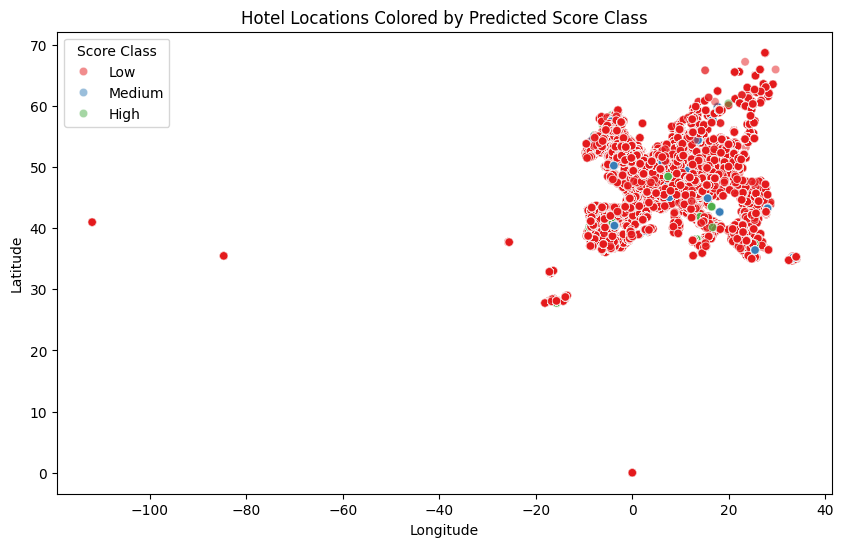

In [30]:
if 'latitude' in X_all.columns and 'longitude' in X_all.columns:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=X_all, x='longitude', y='latitude', hue='Predicted_Class', alpha=0.5, palette='Set1')
    plt.title("Hotel Locations Colored by Predicted Score Class")
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.legend(title='Score Class')
    plt.show()


In [31]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred_rounded)
print(f"✅ Final Rounded Classification Accuracy: {accuracy * 100:.4f}%")


✅ Final Rounded Classification Accuracy: 99.9978%


In [32]:
print("🔍 Classification Report:")
print(classification_report(y_test, y_pred_rounded, target_names=le.classes_))


🔍 Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00      9886
         Low       1.00      1.00      1.00    249615
      Medium       1.00      1.00      1.00     16568

    accuracy                           1.00    276069
   macro avg       1.00      1.00      1.00    276069
weighted avg       1.00      1.00      1.00    276069



In [34]:
from sklearn.metrics import accuracy_score, classification_report

accuracy = accuracy_score(y_test, y_pred_rounded)
print(f"✅ Final Rounded Classification Accuracy: {accuracy * 100:.4f}%\n")
print("🔍 Classification Report:")
print(classification_report(y_test, y_pred_rounded, target_names=le.classes_))
print("\n📊 Model: XGBoost Regressor → rounded to 3-class labels")
print("🎯 Target: Hotel 'Score' → binned into Low / Medium / High")
print("📦 Output: X_all contains predictions, city, hotel name, etc.")


✅ Final Rounded Classification Accuracy: 99.9978%

🔍 Classification Report:
              precision    recall  f1-score   support

        High       1.00      1.00      1.00      9886
         Low       1.00      1.00      1.00    249615
      Medium       1.00      1.00      1.00     16568

    accuracy                           1.00    276069
   macro avg       1.00      1.00      1.00    276069
weighted avg       1.00      1.00      1.00    276069


📊 Model: XGBoost Regressor → rounded to 3-class labels
🎯 Target: Hotel 'Score' → binned into Low / Medium / High
📦 Output: X_all contains predictions, city, hotel name, etc.


In [35]:
y_pred_rounded = np.round(model.predict(X_test)).astype(int)


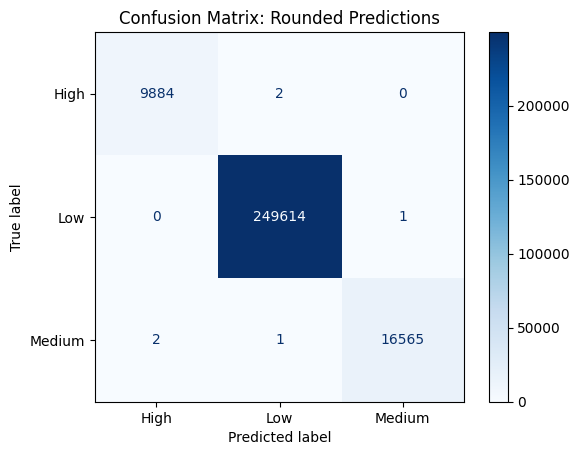

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_rounded)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix: Rounded Predictions")
plt.show()


In [37]:
from sklearn.metrics import f1_score

macro_f1 = f1_score(y_test, y_pred_rounded, average='macro')
print("Macro F1 Score:", macro_f1)


Macro F1 Score: 0.9998896531614356


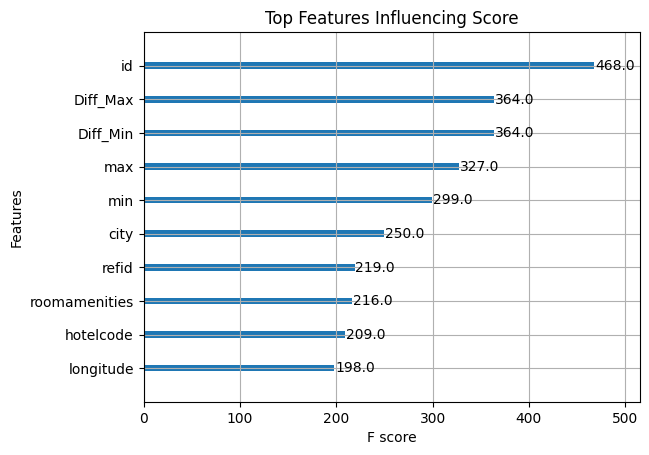

In [38]:
xgb.plot_importance(model, max_num_features=10)
plt.title("Top Features Influencing Score")
plt.show()


In [39]:
import joblib


In [40]:
joblib.dump(model, 'hotel_score_model.pkl')


['hotel_score_model.pkl']

In [41]:
joblib.dump(le, 'score_label_encoder.pkl')


['score_label_encoder.pkl']

In [42]:
from google.colab import files
files.download('hotel_score_model.pkl')
files.download('score_label_encoder.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [44]:
X_all.to_csv('hotel_recommendations.csv', index=False)

from google.colab import files
files.download('hotel_recommendations.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>